In [17]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.optimize import minimize
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
from utilites import preprocess
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, check_random_state
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
import time
from tqdm import tqdm
from math import sqrt
import math
import itertools
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_regression
import numpy as np
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from own_forest import *
from utilites import *
from own_forest import *
from sklearn.base import clone

from memory_profiler import profile

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
import gc

gc.collect()

10

## Алгоритм бэггинга над бустингом эл.кл.

In [4]:
class BaggingElementaryTrees(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator=None, n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, bootstrap=True, bootstrap_features=True, n_jobs=None, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else BoostingElementaryPredicates()
        print(self.base_estimator)
        self.n_estimators = n_estimators
        self.sub_sample_size = sub_sample_size
        self.sub_feature_size = sub_feature_size
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        self.random_state_ = np.random.RandomState(self.random_state)
        seeds = self.random_state_.randint(np.iinfo(np.int32).max, size=self.n_estimators)

        self.estimators_ = []
        self.estimators_features_ = []

        if self.n_jobs is None:
            for seed in seeds:
                estimator, features = self._fit_estimator(X, y, seed)
                self.estimators_.append(estimator)
                self.estimators_features_.append(features)
        else:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_estimator)(X, y, seed) for seed in seeds)
            self.estimators_, self.estimators_features_ = zip(*results)

        return self

    def _fit_estimator(self, X, y, seed):
        rng = np.random.default_rng(seed)
        samples = generate_bagging_indices(rng, X.shape[0], self.sub_sample_size, self.bootstrap)
        if self.bootstrap_features:
            features = generate_bagging_indices(rng, X.shape[1], self.sub_feature_size, self.bootstrap)
        else:
            features = np.arange(X.shape[1])

        estimator = self.base_estimator.__class__(num_iter=11, m=40)
        estimator.fit(X[samples][:, features], y[samples])
        
        return estimator, features

    def predict(self, X):
        # Соберите предсказания от всех деревьев
        predictions = np.mean([est.predict(X[:, features]) for est, features in zip(self.estimators_, self.estimators_features_)], axis=0)
        return predictions

## Подготовка данных

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [6]:
X_train, X_test, y_train, y_test = preprocess(dataset, 'MPG')

## Обучение и подбор параметров бустинга

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)  # sample indices of datasets for 5-fold cv

cv_sets = []
for train_index, test_index in kf.split(X_train):
    cv_sets.append(
        (
            X_train[train_index],
            y_train[train_index],
            X_train[test_index],
            y_train[test_index],
        )
    )  # construct 5-fold cv datasets

In [8]:
from itertools import product

lb_params =  {
    "num_iter" : np.linspace(1, 10, 10).astype(int),
    "m" : np.linspace(5, 59, 20).astype(int),
}

param_combinations = list(product(lb_params["num_iter"], lb_params["m"]))

In [12]:
import logging
import cProfile
import pstats

In [13]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [14]:
def evaluate_combinations():
    for num_iter, m in param_combinations:
        try:
            logging.info(f'Starting evaluation with num_iter={num_iter}, m={m}')
            cv_results = []
            regressor = BoostingElementaryPredicates(num_iter=num_iter, m=m, max_cov=500)
            for x_tr, y_tr, x_te, y_te in cv_sets:
                regressor.fit(x_tr, y_tr)
                cv_results.append(mean_squared_error(regressor.predict(x_te), y_te, squared=False))
            mean_cv_score = np.mean(cv_results)
            logging.info(f'Finished evaluation with num_iter={num_iter}, m={m}, mean_cv_score={mean_cv_score}')
        except Exception as e:
            # Логируем исключение, если что-то пошло не так
            logging.error(f'Error during evaluation with num_iter={num_iter}, m={m}: {e}')
            continue

In [15]:
pr = cProfile.Profile()
pr.enable()

evaluate_combinations()


pr.disable()
stats = pstats.Stats(pr).sort_stats('cumulative')
stats.print_stats()

2024-03-14 02:33:56,812 - INFO - Starting evaluation with num_iter=1, m=5
2024-03-14 02:33:56,873 - INFO - Finished evaluation with num_iter=1, m=5, mean_cv_score=8.136484736754557
2024-03-14 02:33:56,875 - INFO - Starting evaluation with num_iter=1, m=7
2024-03-14 02:33:56,931 - INFO - Finished evaluation with num_iter=1, m=7, mean_cv_score=8.263589885636902
2024-03-14 02:33:56,932 - INFO - Starting evaluation with num_iter=1, m=10
2024-03-14 02:33:56,991 - INFO - Finished evaluation with num_iter=1, m=10, mean_cv_score=8.158712524779553
2024-03-14 02:33:56,992 - INFO - Starting evaluation with num_iter=1, m=13
2024-03-14 02:33:57,052 - INFO - Finished evaluation with num_iter=1, m=13, mean_cv_score=9.170859215952575
2024-03-14 02:33:57,053 - INFO - Starting evaluation with num_iter=1, m=16
2024-03-14 02:33:57,115 - INFO - Finished evaluation with num_iter=1, m=16, mean_cv_score=9.170859215952575
2024-03-14 02:33:57,116 - INFO - Starting evaluation with num_iter=1, m=19
2024-03-14 02:

         32157564 function calls (29840972 primitive calls) in 78.972 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   78.972   39.486 /Users/admin/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        2    0.000    0.000   78.972   39.486 {built-in method builtins.exec}
        1    0.032    0.032   78.972   78.972 /var/folders/6n/8jjs7_ks1vvgsv0l2n5mxvdw0000gn/T/ipykernel_25529/1722631524.py:1(evaluate_combinations)
     1000    9.101    0.009   71.548    0.072 /Users/admin/Desktop/diploma/models.py:23(fit)
3433658/1117066    6.135    0.000   46.840    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   272600    0.447    0.000   39.014    0.000 <__array_function__ internals>:177(isin)
   272600    0.848    0.000   38.150    0.000 /Users/admin/anaconda3/lib/python3.11/site-packages/numpy/lib/arraysetops.py:766(isin)
   272

In [9]:
def rmse(y1, y2):
    return np.mean((y1-y2)**2)**0.5

In [10]:
# Hp tuning with Sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

regressor = BoostingElementaryPredicates(max_cov=500)

lb_params =  {
    "num_iter" : np.linspace(1, 10, 10).astype(int),
    "m" : np.linspace(5, 59, 20).astype(int),
}


scoring_fnc = make_scorer(rmse, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=regressor, param_grid=lb_params, scoring=scoring_fnc, cv=5
)

grid_search = grid_search.fit(X_train, y_train)

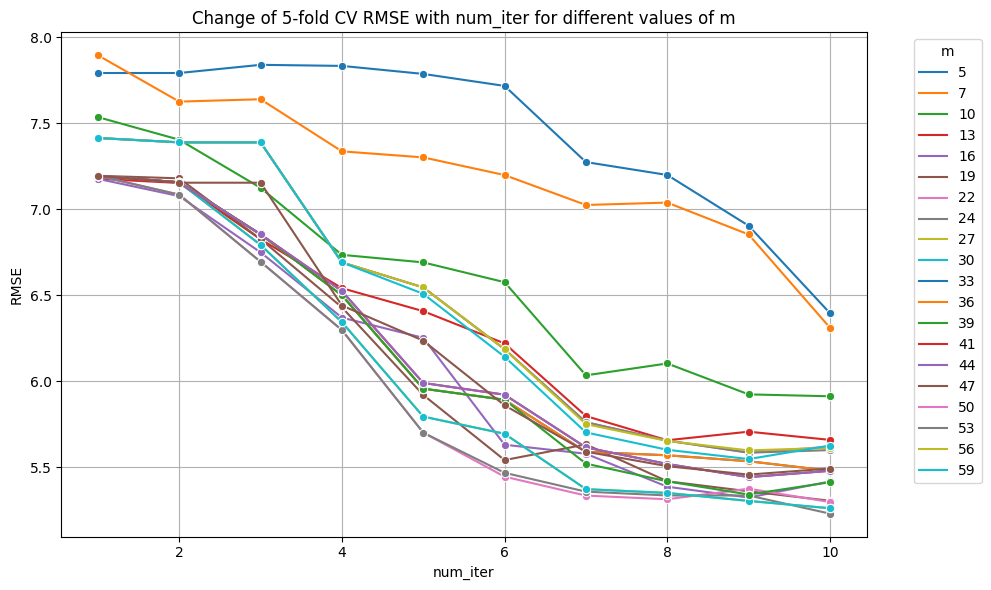

In [18]:
cvres = grid_search.cv_results_

data = []
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    num_iter = params['num_iter']
    m = params['m']
    data.append({"num_iter": num_iter, "m": m, "RMSE": -mean_score})


df = pd.DataFrame(data)

# Строим график
plt.figure(figsize=(10, 6))  
sns.lineplot(data=df, x="num_iter", y="RMSE", hue="m", palette="tab10", marker="o")

plt.title("Change of 5-fold CV RMSE with num_iter for different values of m")
plt.xlabel("num_iter")
plt.ylabel("RMSE")

# Управление легендой вне области графика
plt.legend(title="m", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

## Лучшая модель

In [23]:
grid_search.best_params_
best_regressor = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("Best hyperparameters is {}.".format(grid_search.best_params_))

# Model prediction on training & test data
y_pred_train = best_regressor.predict(X_train)
y_pred_test = best_regressor.predict(X_test)

print("\n--Train RMSE--\n{}".format(mean_squared_error(y_train, y_pred_train, squared=False)))

print("\n--Test RMSE--\n{}\n".format(mean_squared_error(y_test, y_pred_test, squared=False)))


Best hyperparameters is {'m': 24, 'num_iter': 10}.

--Train RMSE--
4.3515273394747735

--Test RMSE--
5.312278835511657



## Кривая на тесте V.S. Кривая на валидации

Number of iters: 1, Test MSE: 6.772531923463126
Number of iters: 2, Test MSE: 6.772531923463126
Number of iters: 3, Test MSE: 6.7737788550725355
Number of iters: 4, Test MSE: 6.609263956642006
Number of iters: 5, Test MSE: 4.796128362614261
Number of iters: 6, Test MSE: 4.835514497224534
Number of iters: 7, Test MSE: 5.351463148104384
Number of iters: 8, Test MSE: 5.221326318897879
Number of iters: 9, Test MSE: 5.221326318897879
Number of iters: 10, Test MSE: 5.312278835511657


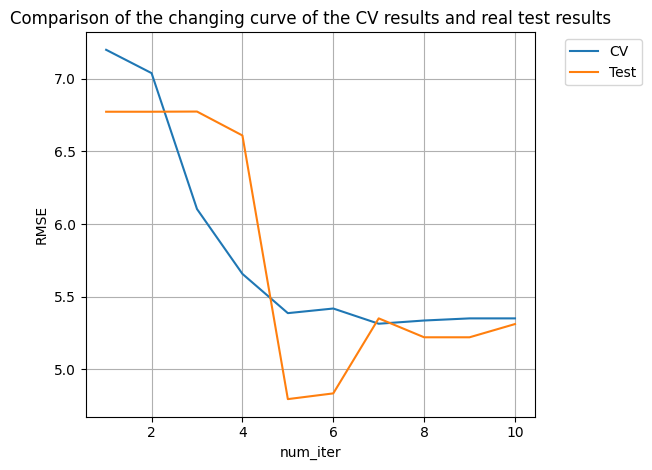

In [56]:
test_results = []
for num_iter in lb_params["num_iter"]:
    tmp_results = []
    regressor = BoostingElementaryPredicates(num_iter=num_iter, m=grid_search.best_params_['m'], max_cov=500)
    regressor.fit(X_train, y_train)
    test_results.append(mean_squared_error(regressor.predict(X_test), y_test, squared=False))
    print("Number of iters: {}, Test MSE: {}".format(num_iter, test_results[-1]))

cv_res = [-cvres["mean_test_score"][i*len(lb_params['num_iter'])+np.where(lb_params['m'] == grid_search.best_params_['m'])[0][0]] for i in range(10)]

plt.plot(lb_params["num_iter"], cv_res)
plt.plot(lb_params["num_iter"], test_results)
plt.title("Comparison of the changing curve of the CV results and real test results")
plt.legend(["CV", "Test"],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("num_iter")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


11


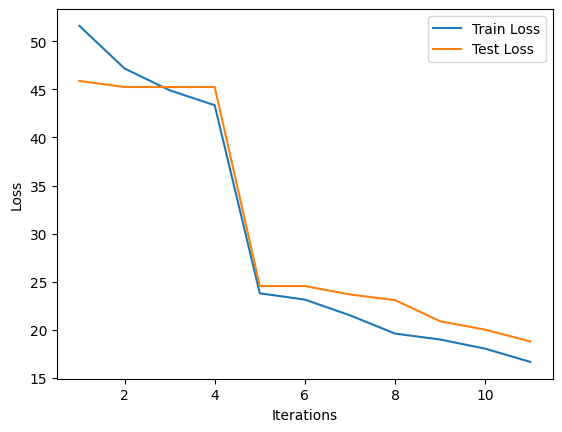

BoostingElementaryPredicates:
Root Mean Squared Error: 4.3362940399670515
R2 Score: 0.6502754378086654


In [57]:
model = BoostingElementaryPredicates1(num_iter=11, m=59) # критическое значение
model.fit_predict(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_test)
print("BoostingElementaryPredicates:")
print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

## Кросс-валидация бустинга на  небольших k $\in [10,20]$

In [60]:
regressor = BoostingElementaryPredicates(max_cov=500)

lb_params =  {
    "num_iter" : np.linspace(1, 50, 20).astype(int),
    "m" : np.linspace(10, 20, 10).astype(int),
}


scoring_fnc = make_scorer(rmse, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=regressor, param_grid=lb_params, scoring=scoring_fnc, cv=5
)

grid_search = grid_search.fit(X_train, y_train)

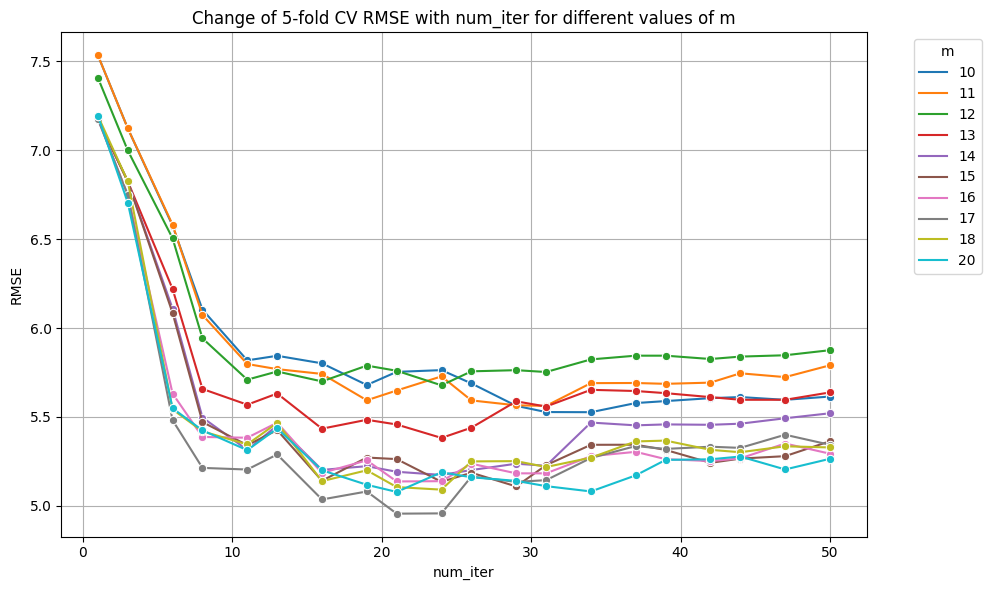

In [62]:
cvres = grid_search.cv_results_

data = []
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    num_iter = params['num_iter']
    m = params['m']
    data.append({"num_iter": num_iter, "m": m, "RMSE": -mean_score})


df = pd.DataFrame(data)

# Строим график
plt.figure(figsize=(10, 6))  
sns.lineplot(data=df, x="num_iter", y="RMSE", hue="m", palette="tab10", marker="o")

plt.title("Change of 5-fold CV RMSE with num_iter for different values of m")
plt.xlabel("num_iter")
plt.ylabel("RMSE")

# Управление легендой вне области графика
plt.legend(title="m", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [63]:
grid_search.best_params_
best_regressor = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("Best hyperparameters is {}.".format(grid_search.best_params_))

# Model prediction on training & test data
y_pred_train = best_regressor.predict(X_train)
y_pred_test = best_regressor.predict(X_test)

print("\n--Train RMSE--\n{}".format(mean_squared_error(y_train, y_pred_train, squared=False)))

print("\n--Test RMSE--\n{}\n".format(mean_squared_error(y_test, y_pred_test, squared=False)))


Best hyperparameters is {'m': 17, 'num_iter': 21}.

--Train RMSE--
3.8585797556471695

--Test RMSE--
5.466912544717763



Number of iters: 1, Test MSE: 6.772531923463126
Number of iters: 3, Test MSE: 6.948730858421034
Number of iters: 6, Test MSE: 6.1089948849773155
Number of iters: 8, Test MSE: 5.92051784027208
Number of iters: 11, Test MSE: 5.752184160468767
Number of iters: 13, Test MSE: 5.64702617946775
Number of iters: 16, Test MSE: 5.641985329595721
Number of iters: 19, Test MSE: 5.805178004847274
Number of iters: 21, Test MSE: 5.466912544717763
Number of iters: 24, Test MSE: 5.360704197360635
Number of iters: 26, Test MSE: 5.350424388882554
Number of iters: 29, Test MSE: 5.480259022975326
Number of iters: 31, Test MSE: 5.5351754748439985
Number of iters: 34, Test MSE: 5.461419413480337
Number of iters: 37, Test MSE: 5.461419413480337
Number of iters: 39, Test MSE: 5.515148432676888
Number of iters: 42, Test MSE: 5.515148432676888
Number of iters: 44, Test MSE: 5.43727664852384
Number of iters: 47, Test MSE: 5.719359400494734
Number of iters: 50, Test MSE: 5.395713249711572


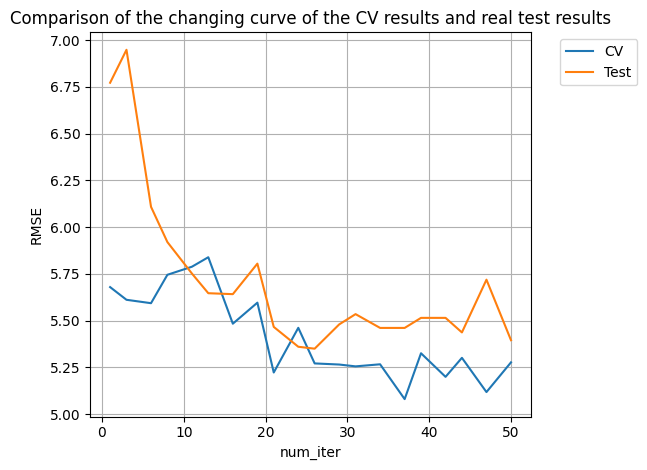

In [77]:
test_results = []
for num_iter in lb_params["num_iter"]:
    tmp_results = []
    regressor = BoostingElementaryPredicates(num_iter=num_iter, m=grid_search.best_params_['m'], max_cov=500)
    regressor.fit(X_train, y_train)
    test_results.append(mean_squared_error(regressor.predict(X_test), y_test, squared=False))
    print("Number of iters: {}, Test MSE: {}".format(num_iter, test_results[-1]))

cv_res = [-cvres["mean_test_score"][i*len(lb_params['m'])+np.where(lb_params['m'] == grid_search.best_params_['m'])[0][0]] for i in range(20)]

plt.plot(lb_params["num_iter"], cv_res)
plt.plot(lb_params["num_iter"], test_results)
plt.title("Comparison of the changing curve of the CV results and real test results")
plt.legend(["CV", "Test"],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("num_iter")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

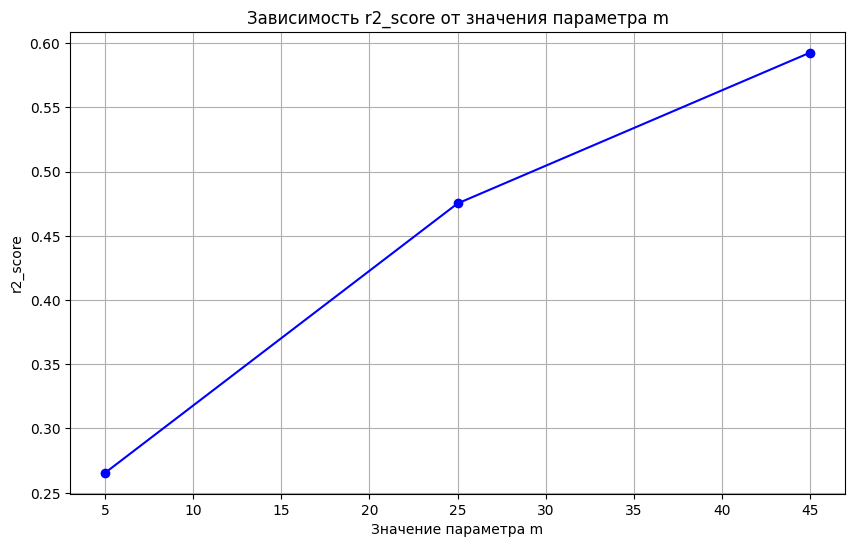

In [59]:
m_values = list(range(5, 59, 20))
r2_scores = []

for m in m_values:
    model = BoostingElementaryPredicates(num_iter=11, m=m)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(m_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость r2_score от значения параметра m')
plt.xlabel('Значение параметра m')
plt.ylabel('r2_score')
plt.grid(True)
plt.show()

Увеличение размерности матрицы сравнения позволяет достичь лучшего качества.

TODO: пофиксить краш ядра JupyterNotebook при матрицах размера >= 60 и посмотреть на распределение весов estimators.

## Обучение и подбор параметров бэггинга

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5)

# Initializing and training the model
model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=59), n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, n_jobs=40)
rmse, r2_score = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=1.0, num_bags=10, num_iter=10, m=20)

print(f"Validation RMSE: {rmse}")
print(f"Validation R2: {r2_score}")

BoostingElementaryPredicates(m=59, num_iter=11)


Validation RMSE: 3.3561221328972786
Validation R2: 0.8268865747130856


In [9]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [10]:
n_estimators_list = [10, 15, 20, 25]  # Список значений для перебора
rmse_values = []  # Сюда будем сохранять значения RMSE

for n_estimators in n_estimators_list:
    model = BaggingElementaryTrees(base_estimator=BoostingElementaryPredicates(num_iter=11, m=40),
                                   n_estimators=n_estimators,
                                   sub_sample_size=1.0,
                                   sub_feature_size=1.0,
                                   n_jobs=-1,  
                                   random_state=42)
    
    # Обучим модель и рассчитаем RMSE. Пример функции train_and_validate:
    # rmse = train_and_validate(model, X_train, y_train, X_val, y_val)
    # Для примера, давайте просто инициализируем модель и запустим fit-predict.
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    current_rmse = rmse(y_val, predictions)
    
    rmse_values.append(current_rmse)
    print(f"n_estimators: {n_estimators}, RMSE: {current_rmse}")

# Построим график RMSE в зависимости от количества деревьев
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, rmse_values, marker='o', linestyle='-')
plt.title('Зависимость RMSE от числа деревьев в бэггинге')
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

BoostingElementaryPredicates(m=40, num_iter=11)


: 

: 

: 

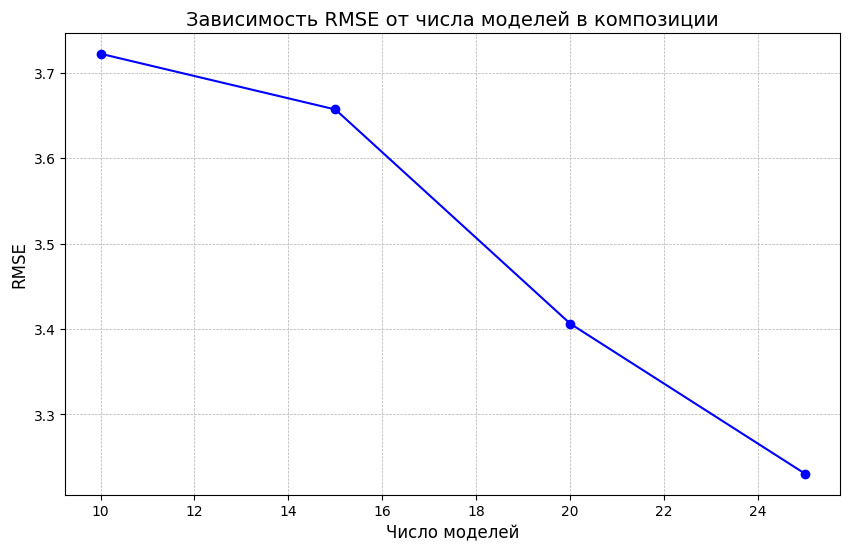

In [8]:
n_estimators = [10, 15, 20, 25]
RMSE = [3.722367952660742, 3.6570967007447826, 3.406334233657796, 3.2306334233657796]

# Создаем график
plt.figure(figsize=(10, 6)) # Размеры графика
plt.plot(n_estimators, RMSE, marker='o', linestyle='-', color='b') # Параметры линии

# Настройка названий и меток
plt.title('Зависимость RMSE от числа моделей в композиции', fontsize=14)
plt.xlabel('Число моделей', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Отображаем сетку для лучшей читаемости
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Показываем график
plt.show()

TODO: пофиксить обучение отдельного estimator'а бэггинга.

##  Эксперименты с различными долями признаков

In [36]:
# fractions = np.linspace(0.55, 1, 4)

# results = []

# for fraction in fractions:
#     rmse = train_and_validate(X_train, y_train, X_val, y_val, fraction, num_bags=10, num_iter=100, m=3)  # Пример параметров
#     results.append({'Fraction': fraction, 'RMSE': rmse})

In [ ]:
fracs = np.linspace(0.1, 1.0, 10)  # Диапазон долей признаков
rmses = []  # Список для хранения результатов

for frac in fracs:
    model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=40), n_estimators=10, sub_feature_size=frac, bootstrap=True, bootstrap_features=True, n_jobs=40, random_state=42)
    rmse = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=frac, num_bags=10, num_iter=10, m=20)
    rmses.append(rmse)

# Отрисовка графиков
plt.figure(figsize=(10, 6))
plt.plot(fracs, rmses, marker='o', linestyle='-', color='b')
plt.title('Зависимость RMSE от доли признаков')
plt.xlabel('Доля признаков')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

: 

: 

: 